In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import scipy.stats as stats
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import StandardScaler

In [56]:
train_data = pd.read_csv("train.csv")

In [57]:
# transform type

train_data[["MoSold", "MSSubClass"]] = train_data[["MoSold", "MSSubClass"]].astype(str)

In [58]:
# separate object and numerical columns. Separate area and surface area columns and year columns as wel

cat_cols = [x for x in train_data.columns if train_data[x].dtype==np.object]
num_cols = [x for x in train_data.columns if train_data[x].dtype!=np.object]
area_cols = [x for x in train_data.columns if ("SF" in x)|("Area" in x)|(x=="LotFrontage")]
year_cols = [x for x in num_cols if 'Yr' in x or 'Year' in x]

In [59]:
# split train and test

X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['Id', 'SalePrice'], axis=1),
                                                    train_data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape


((1314, 79), (146, 79))

In [60]:
# function to calculate elapsed time

def elapsed_years(df, cols):
    # capture difference between year col and
    # year the house was sold
    for col in cols:
        if col=='YrSold':
            continue
        df[col] = df['YrSold'] - df[col]
   
    return df

X_train = elapsed_years(X_train, year_cols)
X_test = elapsed_years(X_test, year_cols)

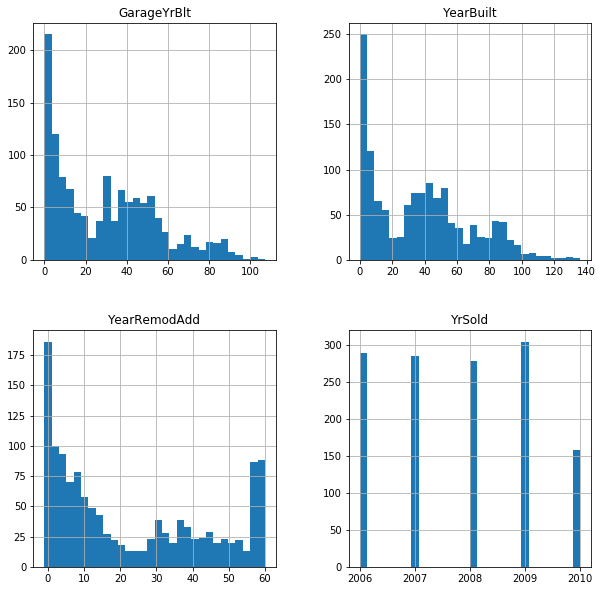

In [61]:
X_train[year_cols].hist(bins=30, figsize=(10,10));


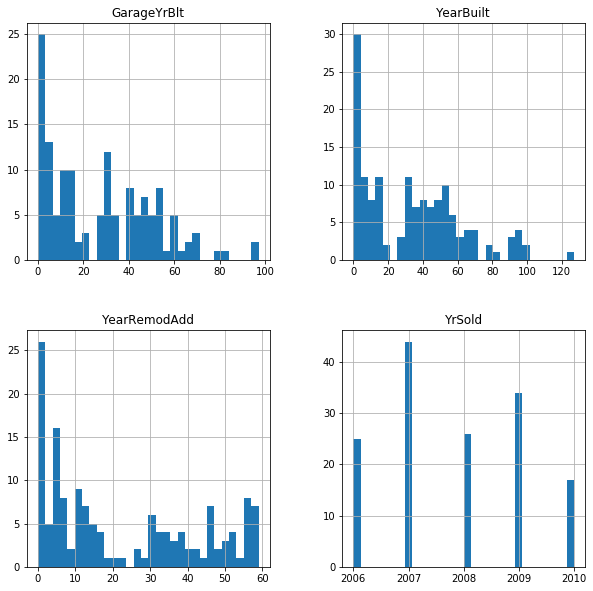

In [62]:
X_test[year_cols].hist(bins=30, figsize=(10,10));

In [63]:
# lets drop cat cols for now and year cols as well

X_train.drop(cat_cols+['YrSold'], axis=1, inplace=True)
X_test.drop(cat_cols+['YrSold'], axis=1, inplace=True)

In [64]:
# lets check missing values
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


In [65]:
# impute with median value

# define an imputation function
def impute_na_median(df, cols):
    for col in cols:
        df[col]= df[col].fillna(df[col].median())
    
    return df

# apply on train set and test set
X_train_imp = impute_na_median(X_train, cols=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])
X_test_imp = impute_na_median(X_test, cols=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])

In [66]:
# transform the area columns to enhance skew

yjt = vt.YeoJohnsonTransformer(variables = area_cols)
yjt.fit(X_train_imp)
print(yjt.lambda_dict_)
X_train_imp_tr = yjt.transform(X_train_imp)
X_test_imp_tr = yjt.transform(X_test_imp)

{'LotFrontage': 0.422432655023388, 'LotArea': -12.55283001172003, 'MasVnrArea': -0.25336100411247126, 'BsmtFinSF1': 0.2241603622191745, 'BsmtFinSF2': -1.5253670841536835, 'BsmtUnfSF': 0.4741451871581765, 'TotalBsmtSF': 0.7320141644679369, '1stFlrSF': -12.55283001172003, '2ndFlrSF': -0.12038141633304861, 'LowQualFinSF': -9.769635009367672, 'GrLivArea': 0.03602357773149543, 'GarageArea': 0.8072365473023602, 'WoodDeckSF': -0.08553433814930124, 'OpenPorchSF': 0.015647864654396017, 'PoolArea': -34.48045639184592}


/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:1478: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [67]:
# scaling the features since we will be using LR

scaler = StandardScaler()
scaler.fit(X_train_imp_tr)

# transform 
X_train_imp_tr_sc = scaler.transform(X_train_imp_tr)
X_test_imp_tr_sc = scaler.transform(X_test_imp_tr)

In [68]:
# make predictions and evaluate model using R2 and RMSE

lr = LinearRegression()
lr.fit(X_train_imp_tr_sc, y_train)

y_pred_train = lr.predict(X_train_imp_tr_sc)
y_pred_test = lr.predict(X_test_imp_tr_sc)

In [69]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
#print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
print()
print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
print('test rmsle: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
print('test r2: {}'.format(r2_score(y_test, y_pred_test)))

train mse: 1242469931.894118
train rmse: 35248.686952766315
train r2: 0.8010084261629333

test mse: 1829214031.3197637
test rmsle: 42769.31179385242
test rmsle: 0.19465008709694837
test r2: 0.7338208171691621


In [70]:
# use a lightgbm regression to quick compare

lightgbm_regr = LGBMRegressor()

lightgbm_regr.fit(X_train_imp_tr_sc, y_train)

y_pred_train = lightgbm_regr.predict(X_train_imp_tr_sc)
y_pred_test = lightgbm_regr.predict(X_test_imp_tr_sc)

In [71]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
#print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
print()
print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
print('test r2: {}'.format(r2_score(y_test, y_pred_test)))

train mse: 161825931.03402546
train rmse: 12721.08214870203
train r2: 0.9740822728361578

test mse: 1188927818.9605024
test rmse: 34480.83263148531
test rmsle: 0.12900898638861805
test r2: 0.8269924514697562


In [72]:
X_train_imp_tr.columns


Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')